<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/coronadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup 
from datetime import date, datetime 

def getCovid19Info(start_date: date, end_date: date): 
  url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19GenAgeCaseInfJson" 
  api_key_utf8 = "zMLNeBeTjLWViEmY%2BV3xqMuqCJVhZ0%2Fv5%2FESR5vFzH%2FQoRNdsotDqTRLcx2Qg10OoS6MseNTQxuIEfKb5lVo1Q%3D%3D" 
  api_key_decode = requests.utils.unquote(api_key_utf8, encoding='utf-8')
  
  params={ "ServiceKey": api_key_decode, 
          "startCreateDt": int('{:04d}{:02d}{:02d}'.format(start_date.year, start_date.month, start_date.day)), 
          "endCreateDt": int('{:04d}{:02d}{:02d}'.format(end_date.year, end_date.month, end_date.day)), 
          } 
          
  response = requests.get(url, params=params) 
  
  return BeautifulSoup(response.text, "lxml")

In [2]:
convert_method = { 
    'confcase':int,
    'confcaserate':float,
    'criticalrate':float,
    'deathrate':float,
    'seq':int,
    'gubun': str, 
    'death': int, 
    'createdt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'), #(x, '%Y-%m-%d %H:%M:%S.%f'), 
    'updatedt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') }

In [3]:
def parsing(items):
  item_list = [] 

  for item in items: 
    item_dict = {} 
    for tag in list(item): 
      try: 
        item_dict[tag.name] = convert_method[tag.name](tag.text) 
      except Exception: 
        item_dict[tag.name] = None 
    item_list.append(item_dict) 
    
  df = pd.DataFrame(item_list)
  return df

### 1. 성별,연령별 

In [568]:
temp = getCovid19Info(date(2020,12,31), date(2021, 7, 9)) 
items = temp.find('items') 
df=parsing(items)

In [569]:
df=df[['confcase','createdt','death','deathrate','gubun']]
df['createdt']=df['createdt'].dt.strftime('%Y-%m-%d')

In [570]:
#성별 비율은 거의 비슷해서 제외
df=df[~(df['gubun']=='여성') & ~(df['gubun']=='남성')]

In [571]:
df=df.reset_index()
df=df.iloc[:,1:]

In [572]:
#gubun이 총 9씩 있는지 확인하기
check9=pd.DataFrame(df.groupby('createdt').count()['gubun'])
check9=check9.reset_index()
check9[check9['gubun']!=9]

,createdt,gubun
65,2021-03-06,17
117,2021-04-27,8
166,2021-06-15,8


In [573]:
df[(df['createdt']=='2021-04-27') | (df['createdt']=='2021-06-15')]

,confcase,createdt,death,deathrate,gubun
216,6631,2021-06-15,0,0.00,0-9
217,10628,2021-06-15,0,0.00,10-19
218,22499,2021-06-15,3,0.15,20-29
219,20653,2021-06-15,8,0.40,30-39
220,27325,2021-06-15,72,3.61,50-59
221,22268,2021-06-15,232,11.65,60-69
222,10108,2021-06-15,566,28.41,70-79
223,5837,2021-06-15,1096,55.02,80 이상
656,5173,2021-04-27,0,0.00,0-9
657,8393,2021-04-27,0,0.00,10-19


In [488]:
df[((df['createdt']=='2021-04-27') | (df['createdt']=='2021-04-28')| (df['createdt']=='2021-04-29')|(df['createdt']=='2021-04-26') )& (df['gubun']=='30-39')]

,confcase,createdt,death,deathrate,gubun
641,16332,2021-04-29,7,0.38,30-39
650,16232,2021-04-28,7,0.38,30-39
667,16051,2021-04-26,7,0.39,30-39


검색을 통해 누적 확진자의 수(6/14-6/15)를 구해서 결측치 채우기

In [574]:
## 원하는 위치에 넣기
new_data = {
    'confcase' : 22697,
    'createdt' : '2021-06-15',
    'death' : 0,
    'deathrate':0,
    'gubun':'40-49'
}

idx = 220 ## 원하는 인덱스
 
temp1 = df[df.index < idx]
temp2 = df[df.index >= idx]
df = temp1.append(new_data,ignore_index=True).append(temp2, ignore_index=True)

In [575]:
## 원하는 위치에 넣기2
new_data = {
    'confcase' : 16114,
    'createdt' : '2021-04-27',
    'death' : 0,
    'deathrate':0,
    'gubun':'30-39'
}

idx = 659 ## 원하는 인덱스
 
temp1 = df[df.index < idx]
temp2 = df[df.index >= idx]
df = temp1.append(new_data,ignore_index=True).append(temp2, ignore_index=True)

In [576]:
df[(df['createdt']=='2021-03-06')]

,confcase,createdt,death,deathrate,gubun
891,3775,2021-03-06,0,0.00,0-9
892,6229,2021-03-06,0,0.00,10-19
893,13903,2021-03-06,1,0.06,20-29
894,12094,2021-03-06,6,0.37,30-39
895,13245,2021-03-06,14,0.86,40-49
896,17095,2021-03-06,54,3.31,50-59
897,14329,2021-03-06,186,11.40,60-69
898,6935,2021-03-06,450,27.57,70-79
899,4447,2021-03-06,921,56.43,80 이상
1143,3775,2021-03-06,0,0.00,0-9


In [577]:
df=df.drop([1143,1144,1145,1146,1147,1148,1149,1150])
df=df.reset_index()
df=df.drop('index',axis=1)

날짜, gubun 순으로 정렬하기

In [578]:
df=df.replace('0-9', 'a.0-9')
df=df.replace('10-19', 'b.10-19')
df=df.replace('20-29', 'c.20-29')
df=df.replace('30-39', 'd.30-39')
df=df.replace('40-49', 'e.40-49')
df=df.replace('50-59', 'f.50-59')
df=df.replace('60-69', 'g.60-69')
df=df.replace('70-79', 'h.70-79')
df=df.replace('80 이상', 'i.80 이상')

In [579]:
df=df.sort_values(by=['createdt','gubun'], axis=0)
df=df.reset_index()
df=df.drop('index',axis=1)
df

,confcase,createdt,death,deathrate,gubun
0,2091,2020-12-31,0,0.00,a.0-9
1,3770,2020-12-31,0,0.00,b.10-19
2,9705,2020-12-31,0,0.00,c.20-29
3,7728,2020-12-31,3,0.33,d.30-39
4,8624,2020-12-31,7,0.78,e.40-49
...,...,...,...,...,...
1714,25784,2021-07-09,15,0.74,e.40-49
1715,30123,2021-07-09,73,3.59,f.50-59
1716,23547,2021-07-09,245,12.03,g.60-69
1717,10437,2021-07-09,583,28.63,h.70-79


In [557]:
df[:20]

,confcase,createdt,death,deathrate,gubun
0,2091,2020-12-31,0,0.00,a.0-9
1,3770,2020-12-31,0,0.00,b.10-19
2,9705,2020-12-31,0,0.00,c.20-29
3,7728,2020-12-31,3,0.33,d.30-39
4,8624,2020-12-31,7,0.78,e.40-49
5,11398,2020-12-31,30,3.33,f.50-59
6,9632,2020-12-31,106,11.78,g.60-69
7,4769,2020-12-31,258,28.67,h.70-79
8,3023,2020-12-31,496,55.11,i.80 이상
9,2132,2021-01-01,0,0.00,a.0-9


잠시만,,,,ㅠ

In [580]:
forday=df['confcase'].reset_index()['confcase']
forday.index=forday.index+9

In [581]:
df['ofday']=forday
df['ofday']=df['ofday'].fillna(0)

In [582]:
df['realofday']=df['confcase']-df['ofday']
df[:20]

,confcase,createdt,death,deathrate,gubun,ofday,realofday
0,2091,2020-12-31,0,0.00,a.0-9,0.0,2091.0
1,3770,2020-12-31,0,0.00,b.10-19,0.0,3770.0
2,9705,2020-12-31,0,0.00,c.20-29,0.0,9705.0
3,7728,2020-12-31,3,0.33,d.30-39,0.0,7728.0
4,8624,2020-12-31,7,0.78,e.40-49,0.0,8624.0
5,11398,2020-12-31,30,3.33,f.50-59,0.0,11398.0
6,9632,2020-12-31,106,11.78,g.60-69,0.0,9632.0
7,4769,2020-12-31,258,28.67,h.70-79,0.0,4769.0
8,3023,2020-12-31,496,55.11,i.80 이상,0.0,3023.0
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0


In [583]:
realreal=df['realofday'][9:]
realreal.index=realreal.index-9
realreal

0        41.0
1        74.0
2       131.0
3       145.0
4       154.0
        ...  
1705    235.0
1706    222.0
1707     77.0
1708     15.0
1709      7.0
Name: realofday, Length: 1710, dtype: float64

In [584]:
df['realreal']=realreal
df

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
0,2091,2020-12-31,0,0.00,a.0-9,0.0,2091.0,41.0
1,3770,2020-12-31,0,0.00,b.10-19,0.0,3770.0,74.0
2,9705,2020-12-31,0,0.00,c.20-29,0.0,9705.0,131.0
3,7728,2020-12-31,3,0.33,d.30-39,0.0,7728.0,145.0
4,8624,2020-12-31,7,0.78,e.40-49,0.0,8624.0,154.0
...,...,...,...,...,...,...,...,...
1714,25784,2021-07-09,15,0.74,e.40-49,25549.0,235.0,NaN
1715,30123,2021-07-09,73,3.59,f.50-59,29901.0,222.0,NaN
1716,23547,2021-07-09,245,12.03,g.60-69,23470.0,77.0,NaN
1717,10437,2021-07-09,583,28.63,h.70-79,10422.0,15.0,NaN


In [585]:
#2021-01-01 이후 행만 추출
df=df[(df['createdt']>='2021-01-01') & (df['createdt']<='2021-07-08')]
df

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0,39.0
10,3844,2021-01-01,0,0.00,b.10-19,3770.0,74.0,66.0
11,9836,2021-01-01,0,0.00,c.20-29,9705.0,131.0,111.0
12,7873,2021-01-01,4,0.44,d.30-39,7728.0,145.0,109.0
13,8778,2021-01-01,7,0.76,e.40-49,8624.0,154.0,106.0
...,...,...,...,...,...,...,...,...
1705,25549,2021-07-08,15,0.74,e.40-49,25330.0,219.0,235.0
1706,29901,2021-07-08,73,3.59,f.50-59,29687.0,214.0,222.0
1707,23470,2021-07-08,245,12.05,g.60-69,23408.0,62.0,77.0
1708,10422,2021-07-08,583,28.66,h.70-79,10401.0,21.0,15.0


전처리 완료.

In [564]:
df[:20]

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
9,2132,2021-01-01,0,0.00,a.0-9,2091.0,41.0,39.0
10,3844,2021-01-01,0,0.00,b.10-19,3770.0,74.0,66.0
11,9836,2021-01-01,0,0.00,c.20-29,9705.0,131.0,111.0
12,7873,2021-01-01,4,0.44,d.30-39,7728.0,145.0,109.0
13,8778,2021-01-01,7,0.76,e.40-49,8624.0,154.0,106.0
14,11602,2021-01-01,30,3.27,f.50-59,11398.0,204.0,160.0
15,9791,2021-01-01,110,12.00,g.60-69,9632.0,159.0,125.0
16,4849,2021-01-01,259,28.24,h.70-79,4769.0,80.0,59.0
17,3064,2021-01-01,507,55.29,i.80 이상,3023.0,41.0,49.0
18,2171,2021-01-02,0,0.00,a.0-9,2132.0,39.0,32.0


1) 연령 구분 없이 하루 확진자 수 구하기

In [531]:
import matplotlib.pyplot as plt
import seaborn as sns

In [586]:
foraccumulate=df.groupby('createdt').sum()['confcase']
foraccumulate=foraccumulate.reset_index()

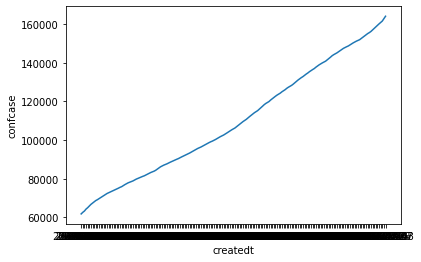

In [587]:
sns.lineplot(data=foraccumulate,x='createdt',y='confcase')

In [588]:
df[(df['createdt']=='2021-03-06') |(df['createdt']=='2021-03-05')|(df['createdt']=='2021-03-07')]

,confcase,createdt,death,deathrate,gubun,ofday,realofday,realreal
576,3754,2021-03-05,0,0.00,a.0-9,3742.0,12.0,21.0
577,6201,2021-03-05,0,0.00,b.10-19,6176.0,25.0,28.0
578,13820,2021-03-05,1,0.06,c.20-29,13759.0,61.0,83.0
579,12031,2021-03-05,6,0.37,d.30-39,11972.0,59.0,63.0
580,13180,2021-03-05,14,0.86,e.40-49,13107.0,73.0,65.0
581,17030,2021-03-05,54,3.32,f.50-59,16955.0,75.0,65.0
582,14270,2021-03-05,186,11.43,g.60-69,14216.0,54.0,59.0
583,6913,2021-03-05,447,27.47,h.70-79,6888.0,25.0,22.0
584,4438,2021-03-05,919,56.48,i.80 이상,4424.0,14.0,9.0
585,3775,2021-03-06,0,0.00,a.0-9,3754.0,21.0,18.0


In [589]:
final_forday=pd.DataFrame(df.groupby('createdt').sum()['realreal'])
final_forday=final_forday.reset_index()

In [590]:
final_forday

,createdt,realreal
0,2021-01-01,824.0
1,2021-01-02,651.0
2,2021-01-03,1020.0
3,2021-01-04,715.0
4,2021-01-05,839.0
...,...,...
184,2021-07-04,711.0
185,2021-07-05,746.0
186,2021-07-06,1212.0
187,2021-07-07,1275.0


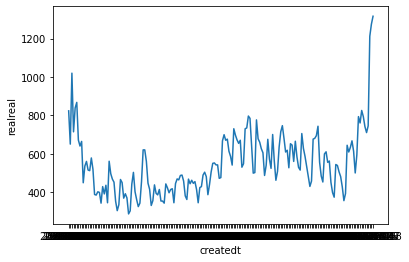

In [591]:

sns.lineplot(data=final_forday,x='createdt',y='realreal')

In [596]:
df[df['gubun']=='a.0-9'][['createdt','realreal']]

,createdt,realreal
9,2021-01-01,39.0
18,2021-01-02,32.0
27,2021-01-03,40.0
36,2021-01-04,45.0
45,2021-01-05,45.0
...,...,...
1665,2021-07-04,43.0
1674,2021-07-05,42.0
1683,2021-07-06,33.0
1692,2021-07-07,57.0


### 2. 지역별 발생현황

In [ ]:
def getCovid19Info_2(start_date: date, end_date: date): 
  url = "http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson" 
  api_key_utf8 = "zMLNeBeTjLWViEmY%2BV3xqMuqCJVhZ0%2Fv5%2FESR5vFzH%2FQoRNdsotDqTRLcx2Qg10OoS6MseNTQxuIEfKb5lVo1Q%3D%3D" 
  api_key_decode = requests.utils.unquote(api_key_utf8, encoding='utf-8')
  
  params={ "ServiceKey": api_key_decode, 
          "startCreateDt": int('{:04d}{:02d}{:02d}'.format(start_date.year, start_date.month, start_date.day)), 
          "endCreateDt": int('{:04d}{:02d}{:02d}'.format(end_date.year, end_date.month, end_date.day)), 
          } 
          
  response = requests.get(url, params=params) 
  
  return BeautifulSoup(response.text, "lxml")

In [ ]:
convert_method = { 
    'confcase':int,
    'confcaserate':float,
    'criticalrate':float,
    'deathrate':float,
    'seq':int,
    'gubun': str, 
    'death': int, 
    'createdt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'), #(x, '%Y-%m-%d %H:%M:%S.%f'), 
    'updatedt': lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') ,
    'gubun':str,
    'incdec':int, #전일대비 증감 수
    'defcnt':int, #DEF_CNT
    'localocccnt':int, #지역발생 수
    'deathcnt':int, #사망자 수
    'isolclearcnt':int,
    'isolingcnt':int,
    'overflowcnt':int,
    'qurrate':float,
    'stdday':str
    }

In [ ]:
temp = getCovid19Info_2(date(2021,1,1), date(2021, 7, 9)) 
items = temp.find('items') 
df_2=parsing(items)

In [ ]:
df_2[:20]